# Customer Attrition Model - Part 4
## Customer Churn Prediction

# 4.0 Notebook Brief

With a large and competitive service such as telecommunication company, it is critical for us be able to predict the customer churn. As stated in early introduction, the goal is to be able to identify then churn customers and ultimately forecast churn on individual customers.

Upon clustering of the customer type for 4 clusters, these information are then used to train the prediction model for churn. In this notebook, we will attempt to model a churn prediction based on past data and measure the model accuracy. We will also investigate what are the important features affecting the churn rate. We will then further dive into the precision-recall curve on the model estimation of churn probability. 

## 4.1 Data Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import preprocessing library
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

#import prepocessing
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

#import classifier models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.naive_bayes import GaussianNB

#import metrics
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, auc

#import bootstrap libs
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline, Pipeline

In [2]:
telco_final = pd.read_csv('../data/telco_clustered.csv')
pd.set_option('display.max_columns',99)

In [3]:
#drop collinear columns
telco = telco_final.copy().drop(columns=['city','churn_reason', 'churn_category','churn_value', 'churn_score',
                            'internet_type','pop_density', 'tenure_months', 'dependents','satisfaction_score','new_user',
                            'referred_a_friend','total_charges','monthly_charge','avg_monthly_long_distance_charges'])

## 4.2 Preprocessing

### 4.2.1 One Hot Encoding

In [4]:
telco_dummified = pd.get_dummies(telco, drop_first=True)
telco_dummified.head()

,gender,age,under_30,senior_citizen,married,number_of_dependents,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,cltv,number_of_referrals,avg_monthly_gb_download,streaming_music,unlimited_data,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,internet_service_Fiber optic,internet_service_No,contract_One year,contract_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,offer_Offer A,offer_Offer B,offer_Offer C,offer_Offer D,offer_Offer E,cluster_minimalist,cluster_price_sensitive,cluster_vanilla
0,0,78,0,1,0,0,0,0,0,0,1,0,0,1,1,5433,0,8,0,0,0.00,20,0.00,59.65,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,1,74,0,1,1,1,1,1,0,1,0,0,0,0,1,5302,1,17,0,1,0.00,0,390.80,1024.10,1,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0
2,0,71,0,1,0,3,1,1,0,0,0,0,1,1,1,3179,0,52,1,1,45.61,0,203.94,1910.88,1,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0
3,1,78,0,1,1,1,1,0,0,1,1,0,1,1,1,5337,1,12,0,1,13.43,0,494.00,2995.07,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,1,80,0,1,1,1,1,1,0,0,0,0,0,0,1,2793,1,14,0,1,0.00,0,234.21,3102.36,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0


### 4.2.2 Train Test Split

In [5]:
X = telco_dummified.drop(columns=['customer_status'])
y = telco_dummified.customer_status

In [6]:
#split with stratify and test size 20%
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   stratify = y, 
                                                    test_size=0.2,
                                                   random_state=42)

## 4.3 Modelling 

### 4.3.1 Baseline Accuracy 

In [7]:
baseline = y.value_counts(normalize=True)
print(f'Dataset: {(baseline[0]*100):.2f}% for Class 0 and {(baseline[1]*100):.2f}% for Class 1')

Dataset: 73.46% for Class 0 and 26.54% for Class 1


At first review, we note that the dataset is already unbalanced with 73% retained customers. In order for the modeling prediction to provide a better insights, we will provide bootstrapping on the target (churn customers) to balance out the Baseline score. 

In [8]:
dummy_clf = DummyClassifier(strategy="most_frequent")
scoring = ["accuracy", "balanced_accuracy"]
cv_result = cross_validate(dummy_clf, X, y, scoring=scoring)
print(f"Accuracy score : {cv_result['test_accuracy'].mean():.3f}")
print(f"Balanced accuracy score : {cv_result['test_balanced_accuracy'].mean():.3f}")

Accuracy score : 0.735
Balanced accuracy score : 0.500


Ideally, the balance dataset accuracy would be 50% hence this will be the used benchmark for the model prediction accuracy. We will use several classifier models paired with standard scaling, SMOTE via oversampling and classifier models in the pipeline for Gridsearch. 

### 4.3.2 Logistic Regression with SMOTE

In [9]:
#Instantiate pipeline 
pipe = Pipeline([
    ('ss' , StandardScaler()),
    ('oversample', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(random_state=42, max_iter=10000))
])

#set pipe params
pipe_params = {
    'logreg__penalty' : ['l2'],
    'logreg__solver' : ['lbfgs'],
    'logreg__C': np.logspace(-2, 1, 1),
    'logreg__class_weight':["balanced"]
}

#gridsearch
gs = GridSearchCV(pipe, pipe_params,  cv=5,n_jobs=-1, scoring='accuracy')
#fit model
gs.fit(X_train, y_train)
best_logreg = gs.best_estimator_

print(f'Logistic Regression Training Accuracy: {best_logreg.score(X_train, y_train):.3f}')
print(f'Logistic Regression Testing Accuracy: {best_logreg.score(X_test, y_test):.3f}')
print('\n')
gs.best_params_

Logistic Regression Training Accuracy: 0.783
Logistic Regression Testing Accuracy: 0.785




{'logreg__C': 0.01,
 'logreg__class_weight': 'balanced',
 'logreg__penalty': 'l2',
 'logreg__solver': 'lbfgs'}

### 4.3.3 Random Forests with SMOTE

In [10]:
#Instantiate pipeline 
pipe = Pipeline([
    ('ss' , StandardScaler()),
    ('oversample', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

#set pipe params
pipe_params = {
    'rf__n_estimators': [100],
    'rf__max_depth': [7],
}

#gridsearch
gs = GridSearchCV(pipe, pipe_params,  cv=5, n_jobs=-1, scoring='accuracy')
#fit model
gs.fit(X_train, y_train)
best_rf = gs.best_estimator_

print(f'Random Forest Training Accuracy: {best_rf.score(X_train, y_train):.3f}')
print(f'Random Forest Testing Accuracy: {best_rf.score(X_test, y_test):.3f}')
print('\n')
gs.best_params_

Random Forest Training Accuracy: 0.820
Random Forest Testing Accuracy: 0.806




{'rf__max_depth': 7, 'rf__n_estimators': 100}

### 4.3.4 Support Vector Machine (SVM) with SMOTE

In [11]:
#Instantiate pipeline 
pipe = Pipeline([
    ('ss' , StandardScaler()),
    ('oversample', SMOTE(random_state=42)),
    ('svc', SVC(random_state=42))
])

#set pipe params
pipe_params = {
    'svc__kernel': ['rbf'],
    'svc__C': [0.01],
}

#gridsearch
gs = GridSearchCV(pipe, pipe_params,  cv=5,n_jobs=-1, scoring='accuracy')
#fit model
gs.fit(X_train, y_train)
best_svc = gs.best_estimator_

print(f'Support Vector Machine Training Accuracy: {best_svc.score(X_train, y_train):.3f}')
print(f'Support Vector Machine Testing Accuracy:{ best_svc.score(X_test, y_test):.3f}')
print('\n')
gs.best_params_

Support Vector Machine Training Accuracy: 0.795
Support Vector Machine Testing Accuracy:0.789




{'svc__C': 0.01, 'svc__kernel': 'rbf'}

## 4.4 Model Selection

We have the logistic regression model, random forest and support vector machine fed with the train and test dataset to measure for its accuracy in prediction. 

In [12]:
#display result in dataframe
model_df = pd.DataFrame({
    'Model' :['Balanced Baseline','Logistic Regression','Random Forest', 'Support Vector Machine'],
    'Training Accuracy' : [0.500, best_logreg.score(X_train, y_train), best_rf.score(X_train, y_train), best_svc.score(X_train, y_train)],
    'Test Accuracy' : [0.500 ,best_logreg.score(X_test, y_test), best_rf.score(X_test, y_test), best_svc.score(X_test, y_test)]
})

model_df[['Training Accuracy', 'Test Accuracy']] = model_df[['Training Accuracy', 'Test Accuracy']].round(3)
model_df

,Model,Training Accuracy,Test Accuracy
0,Balanced Baseline,0.500,0.500
1,Logistic Regression,0.783,0.785
2,Random Forest,0.820,0.806
3,Support Vector Machine,0.795,0.789


Random Forest with SMOTE has scored the highest testing accuracy compared to all other models. This model with its hyperparameters will be used in for the deployment model. 

We will also review its feature importance using Logistic Regression. Further details are in Section 4.7. 

## 4.5 Additional : Neural Networks 

Next, we will put neural network in trial. In the model, we are using 4 hidden layers with ReLu activation and 1 sigmoid output layer. Early stopping was deployed to the model upon convergence of accuracy.

In [13]:
#standardscale
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

#oversampling
over = SMOTE(random_state=42)
X_train_res, y_train_res = over.fit_resample(X_train_sc, y_train)

#define row and cols
m, n_features = X_train.shape

#instantiate model
model = Sequential()

#add 4 hidden layer with dropout 
model.add(Dense(n_features, input_dim=n_features, activation='relu', kernel_regularizer='l1'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

#output with sigmoid 
model.add(Dense(1, activation='sigmoid'))

#compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#add early stoppage
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0.05, patience=10)

#fit data with epochs 80, mini batch 256 and apply early stoppage 
hist = model.fit(X_train_res, y_train_res, validation_data=(X_test_sc, y_test), epochs=80, 
                 batch_size=256, callbacks=[early_stop])

Epoch 1/80
33/33 [==============================] - 1s 23ms/step - loss: 2.7245 - accuracy: 0.5012 - val_loss: 2.3199 - val_accuracy: 0.7452
Epoch 2/80
33/33 [==============================] - 0s 5ms/step - loss: 2.2284 - accuracy: 0.5527 - val_loss: 1.8929 - val_accuracy: 0.7253
Epoch 3/80
33/33 [==============================] - 0s 4ms/step - loss: 1.8131 - accuracy: 0.6354 - val_loss: 1.4682 - val_accuracy: 0.7239
Epoch 4/80
33/33 [==============================] - 0s 3ms/step - loss: 1.4303 - accuracy: 0.7147 - val_loss: 1.1525 - val_accuracy: 0.7374
Epoch 5/80
33/33 [==============================] - 0s 3ms/step - loss: 1.1429 - accuracy: 0.7600 - val_loss: 0.9138 - val_accuracy: 0.7516
Epoch 6/80
33/33 [==============================] - 0s 3ms/step - loss: 0.8939 - accuracy: 0.7910 - val_loss: 0.7221 - val_accuracy: 0.7708
Epoch 7/80
33/33 [==============================] - 0s 3ms/step - loss: 0.7310 - accuracy: 0.8041 - val_loss: 0.6077 - val_accuracy: 0.7906
Epoch 8/80
33/33 [=

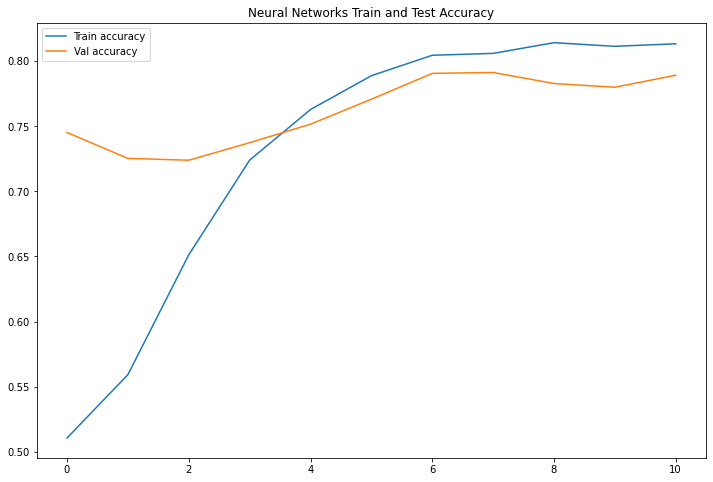

In [14]:
#plot accuracy for train and test 
plt.figure(figsize=(12, 8))
plt.plot(hist.history['accuracy'], label='Train accuracy')
plt.plot(hist.history['val_accuracy'], label='Val accuracy')
plt.title('Neural Networks Train and Test Accuracy')
plt.legend();

In [15]:
#accuracy value for train and test set
nn_train_accuracy = model.evaluate(X_train_sc, y_train, verbose=0)[1]
nn_test_accuracy = model.evaluate(X_test_sc, y_test, verbose=0)[1]
print(f'Neural Network Train Accuracy: {nn_train_accuracy:.3f}')
print(f'Neural Network Test Accuracy: {nn_test_accuracy:.3f}')

Neural Network Train Accuracy: 0.790
Neural Network Test Accuracy: 0.789


The training and testing accuracy of the neural network has not been able to outperform the random forest model. As such, we will continue to use random forest as the final model for deployment.

## 4.6 Model Prediction 

Besides the training and test split testing accuracy, we will also feed the selected model with the entire dataset for evaluation. We will review this is two parts, one of which is the confusion matrix and the other with precision-recall plot. 

In [16]:
#standardscale 
X_sc = StandardScaler().fit_transform(X)

#apply rf model
best_model = best_rf.named_steps['rf']
#predict churn with trained model
y_preds = best_model.predict(X_sc)
y_preds = pd.DataFrame(y_preds)[0]

#compare ytest and prediction
pred_df = pd.merge(y, pd.DataFrame(y_preds.astype(int)), left_index=True, right_index=True)
pred_df = pred_df.rename(columns={'customer_status':'true_values',0:'preds_value'})
pred_df.head()

,true_values,preds_value
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


### 4.6.1 Confusion Matrix

In [17]:
#measure prediction in confusion matrix
cm = confusion_matrix(y, y_preds)

# ravel cm values
tn,fp,fn,tp = cm.ravel()

print(f'True Negatives: {tn}') #predict stay and stayed
print(f'False Positives: {fp}') #predict churn but stayed
print(f'False Negatives: {fn}') #predict stay but churn
print(f'True Positives: {tp}') #predict churn and churned

True Negatives: 3973
False Positives: 1201
False Negatives: 261
True Positives: 1608


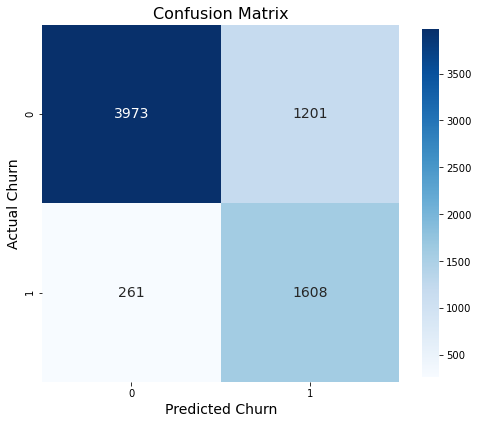

In [22]:
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',square=True, cbar_kws={'shrink':0.8}, annot_kws={'fontsize':14})
plt.title('Confusion Matrix',fontsize=16)
plt.ylabel('Actual Churn', fontsize=14)
plt.xlabel('Predicted Churn', fontsize=14)
# plt.savefig('../images/confusion_matrix.png')

plt.show()

*Interpretation: The prediction shows 1201 of false positives and 261 false negatives. In the prespective of predicting churn customers, we are more concern in both parameters. False postives could provide an insight as to if these are customer that is soon to churn, whereas false negatives gives us an outlook on the model prediction ability.*

In [23]:
#prediction metrics
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (fp + tp) 

print("Sensitivity: ", round(sensitivity,2))
print("Specificity: ", round(specificity,2))
print("Precision:", round(precision ,2))
print("Accuracy: ", round((tn + tp) / (tn + fp + tp + fn),2))
print("Misclassification: ", round((1-(tn + tp) / (tn + fp + tp + fn)),2))

Sensitivity:  0.86
Specificity:  0.77
Precision: 0.57
Accuracy:  0.79
Misclassification:  0.21


The model accuracy is a fair performance but as a sole metric, it would be misleading. The churn prediction model for precision is only shy below 60% while specificity on loyal customers are only ay 77%.

We will look into the precision recall plot next for further analysis on the model performance as after all recall can be thought as of a model’s ability to find all the data points of interest in a dataset.

### 4.6.2 Precision Recall

As in all cases, for higher recall, it is a trade off that affects precision. Hence, we also calculate the f1 score, also known as the harmonic mean score of both precision and recall, which is extremely useful in most scenarios when we are working with imbalanced datasets. 

Random Forest: f1=0.69 auc=0.73


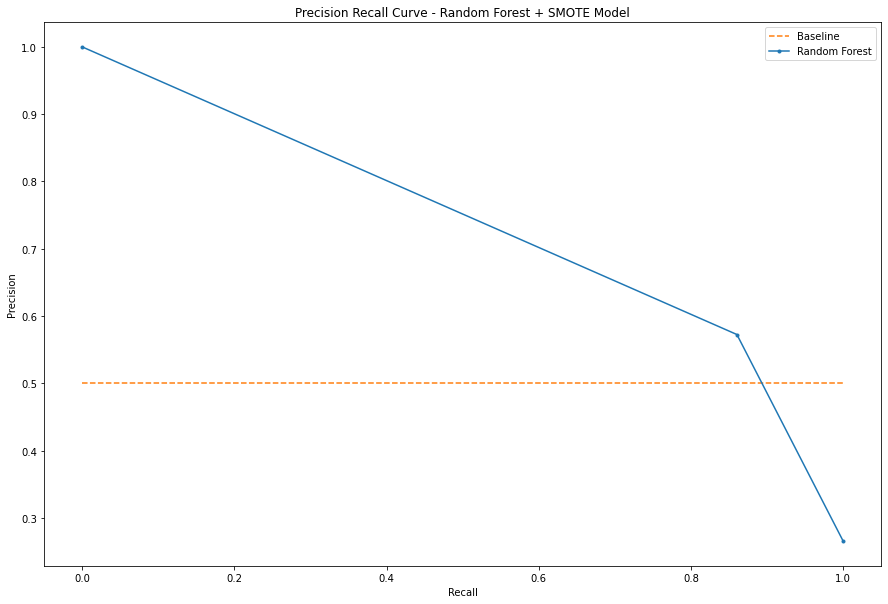

In [39]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y, y_preds)
f1_val = f1_score(y, y_preds)
auc_val = auc(recall, precision)

# summarize scores
print(f'Random Forest: f1={f1_val:.2f} auc={auc_val:.2f}')

#plot precision recall curve for RF model
fig, ax = plt.subplots(figsize=(15, 10))

# precision_recall_curve(best_model,X,y,ax=ax)
plt.plot([0,1],[0.5,0.5], color='tab:orange', linestyle='--', label='Baseline')
plt.plot(recall, precision, marker='.', label='Random Forest')

plt.title('Precision Recall Curve - Random Forest + SMOTE Model')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend()
# plt.savefig('../images/precision_recall.png')
plt.show()

With F1 score of 0.69 and AUC score of 0.73. 
In simplest terms, this means that the model will be able to distinguish the churn customers and those who stayed 73% of the time.

## 4.7 Statistical Inference

In alternative to discern the important features in affecting customer churn, we will use logistic regression model with its coefficient for evaluation.

In [24]:
#identify driving coef 
important_coef = pd.Series(best_logreg.named_steps['logreg'].coef_[0],X.columns)
important_coef.abs().sort_values(ascending=False)

number_of_referrals                       1.113799
contract_Two year                         0.663555
number_of_dependents                      0.485552
married                                   0.465840
internet_service_Fiber optic              0.425056
total_revenue                             0.378793
contract_One year                         0.354371
payment_method_Electronic check           0.189399
tech_support                              0.172013
paperless_billing                         0.158465
internet_service_No                       0.154204
online_backup                             0.148416
online_security                           0.143817
offer_Offer E                             0.142401
offer_Offer D                             0.139483
streaming_music                           0.125950
offer_Offer C                             0.124515
cluster_minimalist                        0.115894
streaming_tv                              0.112633
offer_Offer A                  

From the initial logistic regression coef, we have identified the top 20 columns that has prominent affect to the customer churn. Next, we will retrain the model for features and target without standard scaling in order to measure the odds of each feature. 

### 4.7.1 Important Features

In [32]:
#select top 20 columns
important_cols = important_coef.abs().sort_values().tail(20).index

#specifiy train and target
X_imp = telco_dummified[important_cols]
y_imp = telco_dummified.customer_status

#Instantiate pipeline without standardscale
pipe = Pipeline([
    ('oversample', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(random_state=42, max_iter=10000))
])

#set pipe params
pipe_params = {
    'logreg__penalty' : ['l2'],
    'logreg__solver' : ['liblinear'],
    'logreg__C': np.logspace(-2, 1, 1),
    'logreg__class_weight':["balanced",]
}

#gridsearch
gs = GridSearchCV(pipe, pipe_params,  cv=5,n_jobs=-1, scoring='accuracy')
#fit model
gs.fit(X_imp_train, y_imp_train)
best_logreg = gs.best_estimator_

print(f'Accuracy: {best_logreg.score(X_imp, y_imp):.2f}')

Accuracy: 0.78


In [33]:
#evaluate coef in odds
pd.Series(np.exp(best_logreg.named_steps['logreg'].coef_[0]),X_imp.columns).sort_values()

contract_Two year                  0.439778
cluster_minimalist                 0.475378
internet_service_No                0.479407
contract_One year                  0.489925
online_security                    0.491664
tech_support                       0.494287
online_backup                      0.594946
number_of_dependents               0.620657
number_of_referrals                0.683512
offer_Offer D                      0.715207
offer_Offer C                      0.764550
streaming_music                    0.839802
offer_Offer A                      0.903754
total_revenue                      0.999940
streaming_tv                       1.030565
offer_Offer E                      1.145614
payment_method_Electronic check    1.159979
paperless_billing                  1.199947
married                            1.514662
internet_service_Fiber optic       1.949914
dtype: float64

From the above analysis in priority, with married users are 1.51 times more likely to churn, whereas contract users of two years are 0.43 times more likely to stay. In summary, internet_service using fiber optic, payment method using electronic check, offer E, and streaming tv services are features that the business needs to look into. 

**Questions to ask:**

1. Does *Offer E* has an combination of promotion that has high turnover rate? If yes, what can be done to improve the promotional value of Offer E, else shall Offer E be terminated entirely and be replaced.

2. Does 50% of the *internet service users of fiber optic* has difficulty in connectivity? Is the logistic support for performance of the fiber optic well optimized for the majority of the user base. Is the technical support team well equipt with the knowledge to assist users in need?

3. Does the payment using *electronic check* issue inconvenience to users during payment? If other payment method is viable, is the a lack of information of other payment methods made known to users?

4. Does *streaming tv* shows encounter data limitation? If there is connectivity issues, are these due to lack of infrastucture to support the signal transmissons?

Alternatively, the contracts offers, online security, tech support, online back up has prove to be a value-added service to the users as the subscription to it led to user more likely to stay with the business. 

### 4.7.2 False Positive and False Negative Misclassification

In the confusion matrix in Section 4.6.1,we have identified false positive number of 1201 users and False Negative of 261 users. In this section, we will analyse only the false positive users to verify if the classes were fairly predicted by the model. While for the false negative users, we will run an additional comparison using survivial analysis in the next notebook to evaluate the prediction with our current model.

In [40]:
#predicted to churn but stay
false_po = pred_df[(pred_df.true_values == 0) & (pred_df.preds_value == 1)]
false_po.to_csv('../data/telco_false_po.csv')

#predicted to stay but churned
false_neg = pred_df[(pred_df.true_values == 1) & (pred_df.preds_value == 0)]
false_neg.to_csv('../data/telco_false_neg.csv')

In [41]:
#df for false negative for EDA
false_neg = telco_final.loc[false_neg.index]
false_neg.head()

,gender,age,under_30,senior_citizen,married,dependents,number_of_dependents,city,tenure_months,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,churn_value,churn_score,cltv,churn_reason,referred_a_friend,number_of_referrals,offer,avg_monthly_long_distance_charges,internet_type,avg_monthly_gb_download,streaming_music,unlimited_data,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,satisfaction_score,customer_status,churn_category,pop_density,new_user,cluster
7,0,66,0,1,1,0,0,Sierra Madre,58,0,0,DSL,0,1,1,0,0,1,Month-to-month,1,Electronic check,1,100,5444,Service dissatisfaction,1,6,Offer B,0.00,DSL,24,0,1,45.30,2651.20,40.95,0,0.00,2610.25,1,1,Dissatisfaction,3698,0,vanilla
21,1,70,0,1,0,0,0,El Cajon,54,1,1,DSL,1,1,0,1,1,1,One year,0,Bank transfer (automatic),1,83,4149,Long distance charges,0,0,Offer B,12.08,DSL,5,1,1,82.45,4350.10,0.00,0,652.32,5002.42,1,1,Competitor,5188,0,heavyweight
25,0,79,0,1,1,0,0,Indian Wells,11,1,0,No,0,0,0,0,0,0,Month-to-month,0,Mailed check,1,80,5888,Limited range of services,1,1,None,29.54,None,0,0,0,19.95,214.75,0.00,0,324.94,539.69,1,1,Competitor,358,0,minimalist
35,1,78,0,1,1,0,0,Yorba Linda,65,1,1,Fiber optic,1,0,1,0,1,1,Month-to-month,0,Bank transfer (automatic),1,91,4196,Competitor offered higher download speeds,1,3,Offer B,18.39,Fiber Optic,28,0,1,105.25,6786.40,0.00,0,1195.35,7981.75,1,1,Attitude,2226,0,heavyweight
36,0,75,0,1,1,0,0,Summerland,49,1,1,Fiber optic,0,1,0,0,0,1,Month-to-month,0,Credit card (automatic),1,96,5059,Competitor made better offer,1,3,Offer B,22.92,Fiber Optic,14,0,1,90.05,4547.25,0.00,0,1123.08,5670.33,2,1,Competitor,1519,0,heavyweight


In [42]:
#tenure months
false_neg.tenure_months.value_counts().value_counts()

3     14
1     11
2     11
4     11
5      8
6      8
7      5
8      1
11     1
Name: tenure_months, dtype: int64

The tenure months of the users are far below the expected churn period, with 14 of which are less than 3 months.

In [48]:
#contracts
false_neg.contract.value_counts()

Month-to-month    125
One year           90
Two year           46
Name: contract, dtype: int64

As expected in the contracts, mostly churned users are in the month-to-month users with almost half are from contractual users.

In [52]:
#cluster
false_neg.cluster.value_counts() 

heavyweight        107
vanilla            100
minimalist          44
price_sensitive     10
Name: cluster, dtype: int64

By clusters, most false negative users were coming from heavyweight users, with only some from price_sensitive where misclassified. This suggest a fairly acceptable classfication, as the EDA suggest that most of the users are of the 'non-churn' traits.

In [54]:
#pick numerial features for aggregate
mode_df = false_neg.select_dtypes(exclude='number')
mode_df.groupby('cluster').agg([pd.Series.mode])

,city,internet_service,contract,payment_method,churn_reason,offer,internet_type,churn_category
,mode,mode,mode,mode,mode,mode,mode,mode
cluster,,,,,,,,
heavyweight,Los Angeles,Fiber optic,One year,Bank transfer (automatic),Competitor offered more data,None,Fiber Optic,Competitor
minimalist,San Diego,No,Month-to-month,Mailed check,"[Attitude of support person, Competitor offere...",None,None,Attitude
price_sensitive,"[Altadena, California Hot Springs, Camp Nelson...",Fiber optic,Month-to-month,"[Bank transfer (automatic), Electronic check]",Attitude of support person,None,Fiber Optic,Competitor
vanilla,Los Angeles,DSL,Month-to-month,Mailed check,Competitor offered higher download speeds,None,DSL,Competitor


From the aggregate table above, we note that most users from the city has been expected to stay with the business but has ultimately churned due to the competition. This serves as a red flag for the business to explore and proactively maintain presence in compeitive Los Angeles. 

In [54]:
#overview on the misclassified users by cluster
false_neg.groupby('cluster').agg(['min','max'])[['age','tenure_months','churn_score','cltv','avg_monthly_long_distance_charges',
                                                'avg_monthly_gb_download','monthly_charge','total_charges','total_extra_data_charges',
                                               'total_long_distance_charges','total_revenue']]

age     tenure_months     churn_score       cltv        \
                min max           min max         min  max   min   max   
cluster                                                                  
heavyweight      20  80            32  72          65  100  2071  6452   
minimalist       19  79             1  61          65  100  2102  6484   
price_sensitive  26  75             6  27          68   94  2283  5719   
vanilla          19  80             1  71          65  100  2003  6347   

                avg_monthly_long_distance_charges         \
                                              min    max   
cluster                                                    
heavyweight                                  0.00  49.98   
minimalist                                   2.58  49.74   
price_sensitive                              1.51  49.20   
vanilla                                      0.00  48.93   

                avg_monthly_gb_download     monthly_charge          \
                                    min max            min     max   
cluster                                                              
heavyweight                           2  82          54.20  118.35   
minimalist                            0   0          18.95   25.90   
price_sensitive                       3  51          44.60  104.30   
vanilla                               2  85          28.60  105.95   

                total_charges          total_extra_data_charges       \
                          min      max                      min  max   
cluster                                                                
heavyweight           2934.30  8684.80                        0  150   
minimalist              19.75  1334.00                        0    0   
price_sensitive        260.80  2867.75                        0    0   
vanilla                 49.25  3692.85                        0  150   

                total_long_distance_charges          total_revenue            
                                        min      max           min       max  
cluster                                                                       
heavyweight                            0.00  3508.82       3858.91  11195.44  
minimalist                            11.91  2822.47         31.66   4005.02  
price_sensitive                       27.18   831.60        556.00   3142.88  
vanilla                                0.00  2079.20         57.63   4835.75

Whilst on other services, the CLTV scores of the users ranges in between 2000 to 6400 which are considered in the DIVEST and RETAIN quadrant. Hence, cautionary and importance on being able to correctly identify the customer quadrant and take action as necessary in customer retention. 

Next we will look into the false positive and false negative prediction in the next notebook on the survival analysis verification.

In [61]:
# import pickle

# # export model
# pickle.dump(best_model, open("../model/best_model", "wb"))

# # import model
# best_model_clone = pickle.load(open("../model/best_model", "rb"))